## 1.加载依赖包

In [ ]:
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
import warnings
import gc
from sklearn.preprocessing import StandardScaler
import matplotlib as  mpl
from matplotlib  import pyplot as plt
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings('ignore')

## 2.获取历史数据
功能：针对特定场景数据做相应的处理并打上鼓掌标签，不具备通用性    
输入：dataset.csv（特征数据）和dbd_faultcode.csv（故障记录）  
输出：his_x（特征） 和 his_y（标签），his_x,his_y为处理过历史数据，用于接下来的模型训练

In [6]:
%%time
# 1. 读取数据
dataset = pd.read_csv('./train/dataset.csv', index_col=0)
dbd_faultcode = pd.read_csv('./train/dbd_faultcode.csv', encoding='GBK' )
train_data = dataset.merge(dbd_faultcode,how = 'left',on = ["SPN","FMI"])
up_data = train_data
up_data.COLLECTTIME = pd.to_datetime(up_data.COLLECTTIME)
up_data.sort_values(by='COLLECTTIME', inplace=True)
# 删除明显异常的行
drop_rows = [0, 1, 2, 3]
drop_rows.extend([x for x in range(1875076, 1875088)])
up_data.drop(drop_rows, axis=0, inplace=True)
# 默认填充为0
up_data["FLAG"] = 0
# 筛选出故障编码不为空的UNIQUENO(一个UNIQUENO可假设为一台机器)
prob_uniqs = up_data[up_data.CODE.notnull()].UNIQUENO.unique()

# 2.出现故障的时间段进行标记
'''
minutes = 300
'''
# 设定优先级，对于少数种类的故障，优先标记
code_prev = {
    1206: 0,
    1141: 1,
    1182: 2,
    1168: -1,
    1239: -1,
    1168: -1,
    1211: -1,
    1216: -1,
    1209: -1,
    1145: -1,
    1341: -1,
    1246: -1,
    1215: -1,
    1122: -1
}

delta = timedelta(minutes = 300)
left_delta = delta
right_delta = delta
# 从有故障的设备列表中取出一台设备
for dev_id in prob_uniqs:
    # 取出这台设备的全部数据
    cdf = up_data[up_data.UNIQUENO == dev_id].copy()
    cdf['index'] = cdf.index
    cdf.reset_index(inplace=True)
    # 取出这台设备故障码不为空的数据
    notna_cdf = cdf[cdf.CODE.notna()]
#     print(datetime.now(), dev_id, cdf.shape[0], notna_cdf.shape[0])
    cdf_len = cdf.shape[0]
    # 在这台设备数据中遍历不为空的位置
    for i in notna_cdf.index:
        dt = cdf.at[i, 'COLLECTTIME']
        code = cdf.at[i, 'CODE']
        # 在前后时间间隔内打标签
        for y in range(i, -1, -1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] >= dt - left_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
        
        for y in range(i + 1, cdf_len, 1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] <= dt + right_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break

# 3.保留有用的列
#columns_filter,util_cols由人工提供
columns_filter = ['CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6','FLAG','UNIQUENO','COLLECTTIME']
util_cols = ['COLLECTTIME','FLAG','UNIQUENO']

# 筛选出这四类故障的数据
x_train = up_data[up_data.FLAG.isin({0,1206,1141,1182})]
x_data = x_train[columns_filter]
y_train = x_data['FLAG']
y_train.replace(1206,1,inplace=True)
y_train.replace(1141,2,inplace=True)
y_train.replace(1182,3,inplace=True)
x_data['FLAG'] = y_train.values 
x_data.index = pd.to_datetime(x_data['COLLECTTIME'])

train_x_cols = ['UNIQUENO','CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6']
train_y_col = ['UNIQUENO','FLAG']
his_x = x_data[train_x_cols]
his_y = x_data[train_y_col]

CPU times: user 1min 19s, sys: 8.42 s, total: 1min 27s
Wall time: 1min 27s


## 3.数据处理
参数： start，end(格式：YYYY-mm-dd，自定义选择历史数据的时间范围）  
功能：做特征处理，特征选择，根据历史的健康数据训练出的数据标准化类对象    
输入：his_x,his_y  
输出：
train_ax(DataFrame): 所有特征数据 + UNIQUENO   
train_ay(DataFrame): 所有的标签(FLAG) + UNIQUENO  
train_x(DataFrame): 所有特征数据
train_y(DataFrame): 所有的标签(FLAG)  
train_UNIQUENO(DataFrame):UNIQUENO  

train_x_baseline(DataFrame): 健康的特征数据   
train_x_degraded(DataFrame): 故障的特征数据 

   
selcted_features(list):筛选出来的特征  
train_x_baseline_sel(DataFrame): 经过特征筛选的健康的特征数据  
train_x_degraded_sel(DataFrame): 经过特征筛选的健康故障的特征数据  

train_x_baseline_stand(DataFrame): 标准化的健康故障的特征数据  
scaler(object):数据标准化类对象
 


In [4]:
# 0.自定义历史数据的时间范围
start = '2017-01-01'
end = '2018-12-12'
def get_train(his_x,his_y,start=start, end=end):
    return his_x[start:end],his_y[start:end]
train_ax, train_ay = get_train(his_x,his_y,start='2017-01-01', end='2018-12-12')

# 1.数据预处理
# <1>删除null_col
train_x = train_ax.drop(columns=['UNIQUENO']).copy()
train_y = train_ay.drop(columns=['UNIQUENO']).copy()
null_filter = [col for col in train_x.columns if not train_x[col].isnull().all()] 
train_x = train_x[null_filter] # 不含UNIQUENO
train_UNIQUENO = train_ax[['UNIQUENO']] 
                  
# <2>缺失值处理
train_x.fillna(0,inplace=True)
train_xy = pd.concat([train_x,train_y], axis=1)
# <3>取FLAG=0的数据，即健康数据
train_x_baseline = train_xy[train_xy.FLAG==0].drop(columns=['FLAG'])
train_x_degraded = train_xy[train_xy.FLAG!=0].drop(columns=['FLAG'])


In [5]:
# 3.计算几种metrics
# <1>fisher metric
cols = train_x_baseline.columns
m1 = train_x_baseline.mean().values
m2 = train_x_degraded.mean().values
var1 = train_x_baseline.var().values
var2 = train_x_degraded.var().values
a = (m1-m2)*(m1-m2)
b1 = var1
b2 = var2
b = b1+b2
fisher_score = a/b
fisher_rank = pd.Series(data=fisher_score,index=cols).rank(na_option='drop',ascending=False).sort_values() # rank()不会改变顺序


In [6]:
# 4.根据metric来排序特征，然后选择特征
feature_rank = fisher_rank
feature_rank = feature_rank
selcted_features = list(feature_rank.index[:int(0.4*len(feature_rank))])
train_x_baseline_sel = train_x_baseline[selcted_features]
train_x_degraded_sel = train_x_degraded[selcted_features]
train_x_sel = train_x[selcted_features]


# 5.数据标准化
# <1>定义baseline数据标准化函数
def standard_scale(x):
    if x.shape[0]==0:
        return x,0,0
    idx = x.index
    m = x.mean()
    std = x.std()
    scaler = StandardScaler()
    scaler.fit(x)
    x_arr = scaler.transform(x)
    return pd.DataFrame(x_arr, index = idx, columns =x.columns),scaler

# <2>使用健康数生成的scaler，定义对所有测试的数据做归一化标准化的函数
def standard_scale_new(data,scaler):
    cols = data.columns
    idx = data.index
    data_s = scaler.transform(data.values)
    return pd.DataFrame(data=data_s,columns=cols,index=idx)

train_x_baseline_stand,scaler = standard_scale(train_x_baseline_sel)

## 4.健康模型训练和保存
功能：健康模型训练和保存  
输入：train_x_baseline_stand  
输出：  
pca(object):健康模型

In [7]:
# pca and T2
import joblib
import os
from sklearn.decomposition import PCA
def dimension_reduction(x,whiten=True):
    pca = PCA(n_components=0.95,whiten=whiten).fit(x)
    return pca

def cal_T2(data,pca):
    T2=[]
    projected_data = pca.transform(data)
    eigenvalue_matrix = np.mat(np.diag(pca.singular_values_ ))
    for x in projected_data:
        tmp = np.mat(x)*np.linalg.inv(eigenvalue_matrix)*np.mat(x).T
        T2.append(tmp[0,0])
    return T2
      
# 使用归一化的健康数据
pca = dimension_reduction(train_x_baseline_stand.values,whiten=False)
if not os.path.exists('model'):
    os.mkdir('./model')
# 保存pca模型
joblib.dump(pca,'./model/pca_%s_%s.pkl'%(start,end))

['./model/pca_2017-01-01_2018-12-12.pkl']

## 5.健康分排序
参数： start，end(格式：YYYY-mm-dd，自定义选择历史数据的时间范围）  
功能：给定时间范围，计算所有的设备的健康分数排序  
输入：his_x,his_y  
输出：score_rank(Series)

In [1]:
import os
import datetime as dt
from datetime import timedelta


def gen_interval(data,y,scaler,UNIQUENO,selcted_features,start='2017-03-01',end='2018-10-12'):
   # 指定时间间隔，UNIQUENO，返回 可以直接用于计算的数据（已做过相同的特征处理）
    # 1.选数据
    if UNIQUENO == -1:
        data_unino = data.drop(columns=['UNIQUENO'])
        y_unino  =y.drop(columns=['UNIQUENO'])
    else:
    # <1> 选设备
        data_unino = data[data.UNIQUENO==UNIQUENO].drop(columns=['UNIQUENO'])
        y_unino = y[y.UNIQUENO==UNIQUENO].drop(columns=['UNIQUENO'])

    # <2> 选时间片段
    data_date = data_unino[start:end]
    y_date = y_unino[start:end]
    data_date.sort_index(inplace=True)
    y_date.sort_index(inplace=True)
    # <3> 选特征
    data_sel = data_date[selcted_features]
    if data_sel.empty:
        return data_sel,data_date
    
    # 2.相同的特征处理
    # <1> fillna
    data_sel.fillna(0,inplace=True)
    # <2>标准化
    data_stand = standard_scale_new(data_sel,scaler)
    return data_stand,y_date

# data_stand,y_date = gen_interval(his_x,his_y,scaler,UNIQUENO,selcted_features,start='2018-04-25',end='2018-04-30')

In [19]:
def cal_all_T2(x,y,scaler,selcted_features,start='2017-03-01',end='2018-10-12'):
    unino = y.UNIQUENO.value_counts().index[:100]
    res = dict()
    for UNIQUENO in unino:
        # 1.提取符合条件的数据
        data,_ = gen_interval(x, y, scaler, UNIQUENO, selcted_features, start, end)
        # 2.计算T2值
        if data.empty:
            print('%s至%s,id为%d的设备无数据！'%(start,end,UNIQUENO))
            continue
        T2 = cal_T2(data,pca)
        T2 = pd.DataFrame(data=T2,columns=['T2'], index=data.index)
        T2_ewm = T2.ewm(alpha=0.4).mean()
        T2_ewm_mean = T2_ewm['T2'].mean()
        res[UNIQUENO] = T2_ewm_mean
        # 输出T2_ewm(DataFrame)
    score_rank = pd.Series(res).rank(method='dense',ascending=True).sort_values() # T2值大，排名靠后
    return score_rank

In [20]:
%%time
# 计算指定天的分数
score_rank = cal_all_T2(his_x,his_y,scaler,selcted_features,start='2018-04-23',end='2018-04-27')

2018-04-23至2018-04-27,id为201710211430023374的设备无数据！
2018-04-23至2018-04-27,id为201701061100251460的设备无数据！
CPU times: user 16.9 s, sys: 1min 50s, total: 2min 7s
Wall time: 10.7 s


In [21]:
score_rank

201702251130053442     1.0
201512231030009939     2.0
201702150930022662     3.0
201701061057011443     4.0
201707201630029534     5.0
201703061008214110     6.0
201701061057021452     7.0
201701061057021458     8.0
201711151530004024     9.0
201601231030021592    10.0
201703201230014938    11.0
201702211030013081    12.0
201801261730005948    13.0
201703080930044268    14.0
201706051100098485    15.0
201702251130053444    16.0
201711271129594229    17.0
201703101230034529    18.0
201701131530071699    19.0
201702081330022189    20.0
201512231030009937    21.0
201703191430034905    22.0
201601231030021591    23.0
201610211330067937    24.0
201601250830021604    25.0
201612160830029882    26.0
201601191830011465    27.0
201701061057021455    28.0
201705272357138269    29.0
201703121021324582    30.0
                      ... 
201704181630016205    69.0
201703301735255408    70.0
201706071000178525    71.0
201708031930001041    72.0
201703280830045243    73.0
201705101530077175    74.0
2

## 6.画图像
参数：start，end(格式：YYYY-mm-dd，自定义选择历史数据的时间范围）  
功能：给定时间范围，画T2值随时间的变化和FLAG随时间的变化  
输入:his_x,his_y,scaler,selcted_features  
输出:
T2(DataFrame):T2值序列  
T2_ewm(DataFrame):平滑化的T2值序列  
y_date(DataFrame):FLAG序列



In [22]:
def plot_data(his_x,his_y,scaler,UNIQUENO,selcted_features,start='2018-04-23',end='2018-04-27'):
    data_stand,y_date = gen_interval(his_x,his_y,scaler,UNIQUENO,selcted_features,start,end)
    T2 = cal_T2(data_stand,pca)
    T2 = pd.DataFrame(data=T2,columns=['T2'], index=data_stand.index)
    T2_ewm = T2.ewm(alpha=0.4).mean()
    T2_ewm.plot()
    y_date.plot()
    return T2,T2_ewm,y_date

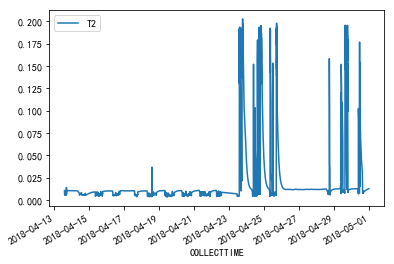

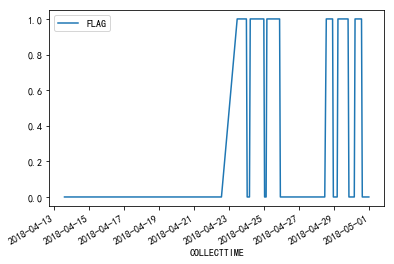

In [23]:
'''
201706130830038670
201707201730009538
201801261730005948
201705272357138269    
'''

'''
全为健康的样本：
201706130830038669
201601250830021604
201612151430019861
201702251130053444
'''
UNIQUENO = 201707201730009538
T2,T2_ewm,y_date = plot_data(his_x,his_y,scaler,UNIQUENO,selcted_features,start='2018-04-01',end='2018-04-30')

## 7.查看baseline、degraded的分布,得到健康基线 error_line和warning_line
参数：start，end(格式：YYYY-mm-dd，自定义选择历史数据的时间范围）  
超参数（确定基线的阈值）：x1(baseline对应的分位数),x2(degraded对应的分位数)  
功能：查看给定时间范围内的baseline、degraded的分布,得到健康基线 error_line和warning_line  
输入：his_x,his_y,scaler,selcted_features  
输出：baseline_per95(warning line),degraded_per05(error line)

In [26]:
def plot_T2(his_x,his_y,scaler,UNIQUENO,selcted_features,start='2018-04-01',end='2018-04-30'):
    data_stand,y_date = gen_interval(his_x,his_y,scaler,UNIQUENO,selcted_features,start,end)
    T2 = cal_T2(data_stand,pca)
    T2 = pd.DataFrame(data=T2,columns=['T2'], index=data_stand.index)
    T2_ewm = T2.ewm(alpha=0.4).mean()
    T2_ewm.plot()
    y_date.plot()
    return T2,T2_ewm,y_date

CPU times: user 55 s, sys: 4min 17s, total: 5min 12s
Wall time: 26.4 s


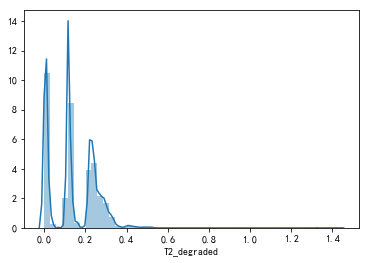

In [27]:
%%time
# 使用所有的故障数据，因为故障数据较少
train_degraded_stand = standard_scale_new(train_x_degraded_sel,scaler)
T2_degraded = cal_T2(train_degraded_stand,pca)
T2_degraded = pd.DataFrame(data=T2_degraded,columns=['T2_degraded'], index=train_degraded_stand.index)
sns.distplot(T2_degraded.T2_degraded)

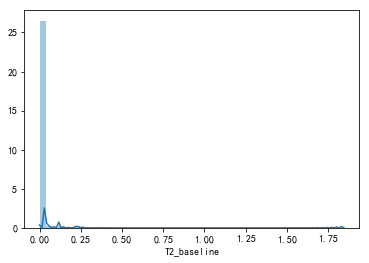

In [28]:
# 健康数据
T2_baseline = cal_T2(train_x_baseline_stand,pca)
T2_baseline = pd.DataFrame(data=T2_baseline,columns=['T2_baseline'], index=train_x_baseline_stand.index)
sns.distplot(T2_baseline.T2_baseline)

In [31]:
# 数据标签并不是完全正确的
x1 = 95 # baseline对应的分位数
x2 = 5 # degraded对应的分位数
baseline_per95 = np.percentile(T2_baseline.values,x1)
degraded_per05 = np.percentile(T2_degraded[T2_degraded.T2_degraded>baseline_per95].values,x2)

error_line = (baseline_per95+degraded_per05)/2
warning_line = baseline_per95

In [61]:
T2_degraded.head()

,T2_degraded
COLLECTTIME,
2018-04-01 02:21:54,0.011479
2018-04-01 02:32:02,0.014572
2018-04-01 02:34:51,0.014102
2018-04-01 02:37:57,0.011815
2018-04-01 02:39:22,0.011876


In [32]:
baseline_per95,degraded_per05

(0.029813397251750716, 0.11420277289923544)

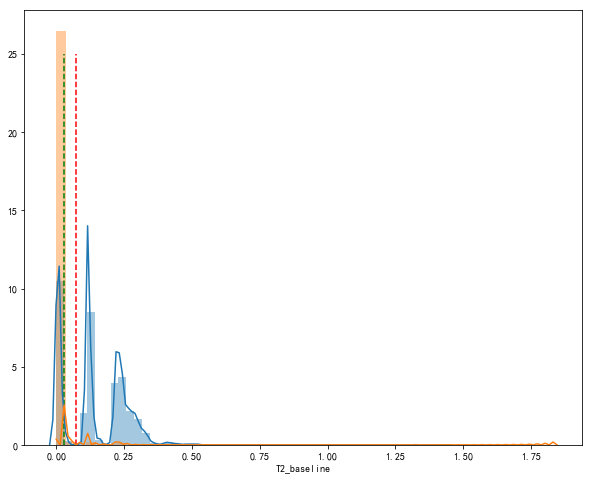

In [33]:
plt.figure(figsize=(10,8))
sns.distplot(T2_degraded.T2_degraded)
sns.distplot(T2_baseline.T2_baseline)
plt.vlines(warning_line,0,25,'g','dashed')
plt.vlines(error_line,0,25,'r','dashed')

## 8.根据T2值计算分数
功能：计算分数  
输入：T2_ewm(平滑化的T2值）  
输出：health_score  

In [49]:
# error_line的分数
s1 = 0.6
x1 = error_line
# warning_line的分数
s2 = 0.7
x2 = warning_line
def gen_score_model(s1,s2,x1,x2):
    k=(np.log(1/s1-1)-np.log(1/s2-1))/(x2-x1)
    b = -np.log(1/s1-1)-k*x1
    return k,b
def sigmod(x,k,b):
    return 1/(1+np.exp(-(k*x+b)))

In [50]:
k,b = gen_score_model(s1,s2,x1,x2)

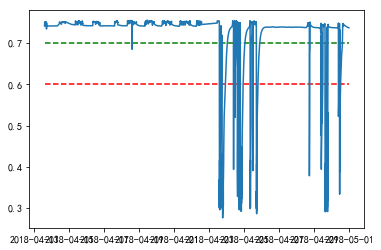

In [58]:
health_score = sigmod(T2_ewm.T2.values,k,b)
plt.plot(T2_ewm.index,health_score)
plt.hlines(s1,T2_ewm.index[0],T2_ewm.index[-1],'r','dashed')
plt.hlines(s2,T2_ewm.index[0],T2_ewm.index[-1],'g','dashed')

## 9.计算每一维的贡献度  
参数： start，end,UNIQUENO(格式：YYYY-mm-dd，自定义选择历史数据的时间范围）
功能：给定时间范围，计算指定设备的每一维的贡献度  
输入：his_x,his_y,selcted_features,pca
输出：contrib(Series)

In [146]:
def cal_fea_T2(data,pca):
    '''
    data(DataFrame):m个样本，n个维度
    '''
    # 计算总得分
#     T2 = cal_T2(data,pca)
    # 计算每个维度的得分
    T2_cols = []
    cols = list(data.columns)
    for i in range(len(cols)):
        tmp = np.zeros(data.shape)
        tmp[:,i] = data.iloc[:,i].values
        T2_col = cal_T2(tmp,pca)
        T2_cols.append(T2_col)
        
#     T2 =np.array(T2).reshape((-1,1))
    T2_cols = np.array(T2_cols).T
#     T2_all = np.concatenate((T2,T2_cols),axis=1)
#     return pd.DataFrame(data=T2_all, columns=['T2']+cols, index = data.index)
    return pd.DataFrame(data=T2_cols,columns=cols,index=data.index)

def cal_contrib(his_x,his_y,scaler,UNIQUENO,selcted_features,pca,start='2017-04-23',end='2018-04-27'):
    data_stand,y_date = gen_interval(his_x,his_y,scaler,UNIQUENO,selcted_features,start,end)
    result = cal_fea_T2(data_stand,pca)
    res_mean = result.mean(axis=0)
    res_sum = res_mean.sum()
    contrib = res_mean/res_sum
    contrib = contrib.sort_values(ascending=False)
    return contrib

In [136]:
contrib = cal_contrib(his_x,his_y,scaler,UNIQUENO,selcted_features,pca,start='2018-04-22',end='2018-04-26')